In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

# install mtcnn
!pip install mtcnn

# libraries
import os
from PIL import Image
import numpy as np
from mtcnn.mtcnn import MTCNN
from tqdm import tqdm

# face crop function
detector = MTCNN()
target_size = (224, 224)

def crop_face_and_save(input_path, output_path):
    image = Image.open(input_path).convert('RGB')
    img_array = np.asarray(image)

    faces = detector.detect_faces(img_array)
    if faces:
        x, y, width, height = faces[0]['box']
        x, y = max(0, x), max(0, y)  # ensures coords arenot negative
        face = img_array[y:y+height, x:x+width]
        face_img = Image.fromarray(face).resize(target_size)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        face_img.save(output_path)


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.3 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = "/content/drive/MyDrive/Capstone2025_DeepfakeDetection/data/frames_cropped_split"
batch_size = 32
image_size = (224, 224)

# augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

# generators
train_gen = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = test_val_datagen.flow_from_directory(
    os.path.join(data_dir, 'val'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = test_val_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 2670 images belonging to 2 classes.
Found 563 images belonging to 2 classes.
Found 578 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# load base model
base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))
base_model.trainable = False  # Freeze base

# add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/tmp/ipython-input-447386017.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# callbacks
checkpoint_path = '/content/drive/MyDrive/Capstone2025_DeepfakeDetection/mobilenet_face_best.h5'
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, save_best_only=True)
]

# train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5795 - loss: 0.7114

84/84 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.5800 - loss: 0.7107 - val_accuracy: 0.7194 - val_loss: 0.5683
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6739 - loss: 0.5998

84/84 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.6739 - loss: 0.5997 - val_accuracy: 0.7140 - val_loss: 0.5587
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7205 - loss: 0.5455

84/84 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.7205 - loss: 0.5455 - val_accuracy: 0.7265 - val_loss: 0.5178
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7192 - loss: 0.5504

84/84 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.7192 - loss: 0.5502 - val_accuracy: 0.7371 - val_loss: 0.5164
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7486 - loss: 0.4994

84/84 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.7485 - loss: 0.4995 - val_accuracy: 0.7584 - val_loss: 0.4997
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7403 - loss: 0.4919

84/84 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.7404 - loss: 0.4919 - val_accuracy: 0.7513 - val_loss: 0.4651
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7569 - loss: 0.4721

84/84 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.7569 - loss: 0.4720 - val_accuracy: 0.7940 - val_loss: 0.4401
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7812 - loss: 0.4379

84/84 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.7811 - loss: 0.4381 - val_accuracy: 0.7851 - val_loss: 0.4362
Epoch 9/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7656 - loss: 0.4638

84/84 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.7658 - loss: 0.4636 - val_accuracy: 0.8064 - val_loss: 0.4145
Epoch 10/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8101 - loss: 0.4118

84/84 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.8101 - loss: 0.4118 - val_accuracy: 0.8224 - val_loss: 0.3882
Epoch 11/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.8122 - loss: 0.3918 - val_accuracy: 0.7957 - val_loss: 0.4210
Epoch 12/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.7887 - loss: 0.4334 - val_accuracy: 0.8153 - val_loss: 0.3935
Epoch 13/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8153 - loss: 0.4061

84/84 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.8152 - loss: 0.4060 - val_accuracy: 0.8366 - val_loss: 0.3824
Epoch 14/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.8237 - loss: 0.3873 - val_accuracy: 0.8153 - val_loss: 0.3995
Epoch 15/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.8125 - loss: 0.3938 - val_accuracy: 0.8117 - val_loss: 0.3894
Epoch 16/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8310 - loss: 0.3778

84/84 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.8310 - loss: 0.3777 - val_accuracy: 0.8135 - val_loss: 0.3589
Epoch 17/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.8227 - loss: 0.3857 - val_accuracy: 0.8401 - val_loss: 0.3619
Epoch 18/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.8409 - loss: 0.3508 - val_accuracy: 0.8277 - val_loss: 0.3590
Epoch 19/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8367 - loss: 0.3543

84/84 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.8367 - loss: 0.3544 - val_accuracy: 0.8384 - val_loss: 0.3438
Epoch 20/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.8360 - loss: 0.3530 - val_accuracy: 0.8544 - val_loss: 0.3501


In [ ]:
# Loadthe best saved model
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Capstone2025_DeepfakeDetection/mobilenet_face_best.h5')

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8820 - loss: 0.3010
Test Accuracy: 0.8979 | Test Loss: 0.2775


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


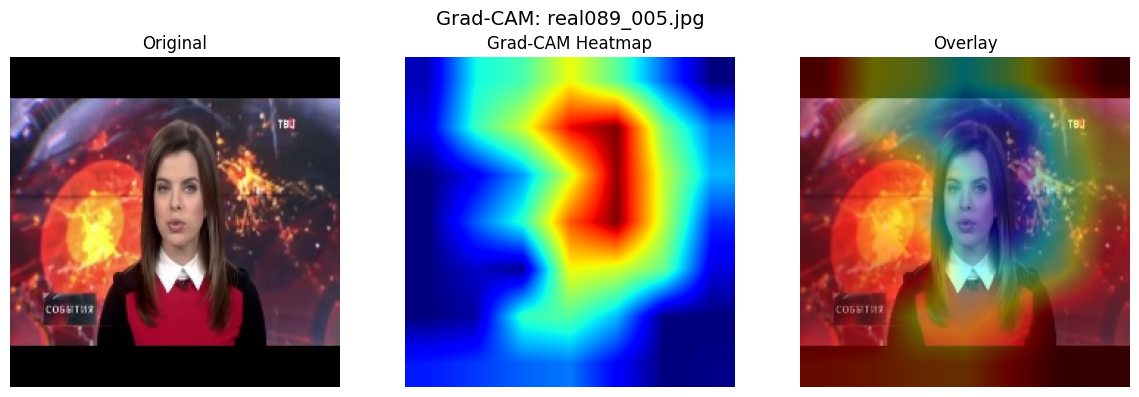

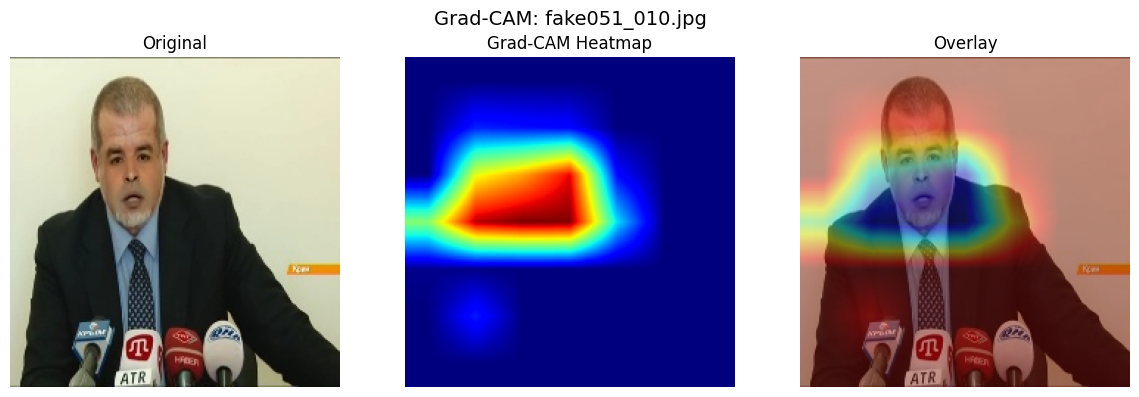

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model

model_path = '/content/drive/MyDrive/Capstone2025_DeepfakeDetection/mobilenet_face_best.h5'
model = tf.keras.models.load_model(model_path)

# Set image size based on training setup
img_size = (224, 224)

#Choose any test images (real and fake)
image_paths = [
    '/content/drive/MyDrive/Capstone2025_DeepfakeDetection/data/frames_split/test/real/real089_005.jpg',
    '/content/drive/MyDrive/Capstone2025_DeepfakeDetection/data/frames_split/test/fake/fake051_010.jpg'
]

# Load and preprocess image
def load_and_preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    return np.expand_dims(img_array, axis=0), img

# grad-CAM visualization
def make_gradcam_heatmap(model, img_array, last_conv_layer_name='Conv_1'):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Display results
def display_gradcam(img_path, heatmap, original_img, alpha=0.4):
    heatmap_resized = cv2.resize(heatmap, img_size)
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    original_img_np = np.array(original_img).astype("uint8")
    superimposed_img = cv2.addWeighted(original_img_np, 1 - alpha, heatmap_colored, alpha, 0)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_resized, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title("Overlay")
    plt.axis("off")

    plt.suptitle(f"Grad-CAM: {os.path.basename(img_path)}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Grad-CAM of selected images
for path in image_paths:
    img_array, original_img = load_and_preprocess_image(path)
    heatmap = make_gradcam_heatmap(model, img_array)
    display_gradcam(path, heatmap, original_img)


19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8820 - loss: 0.3010
✅ Recompiled model - Test Accuracy: 0.8979 | Loss: 0.2775
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step

Classification Report:
              precision    recall  f1-score   support

        fake       0.93      0.86      0.89       288
        real       0.87      0.93      0.90       290

    accuracy                           0.90       578
   macro avg       0.90      0.90      0.90       578
weighted avg       0.90      0.90      0.90       578



<Figure size 600x500 with 0 Axes>

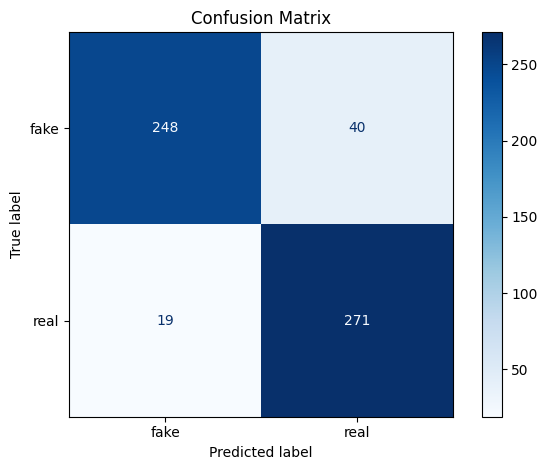

In [ ]:
from keras.models import load_model
from keras.optimizers import Adam

# Load best model
model = load_model(best_model_path)

# Recompile for binary classification
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])
loss, acc = model.evaluate(test_gen)
print(f" Recompiled model - Test Accuracy: {acc:.4f} | Loss: {loss:.4f}")
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict probabilities
y_pred_prob = model.predict(test_gen)
# Convert to binary labels using threshold 0.5
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# True labels
y_true = test_gen.classes

# Labels
class_names = ['fake', 'real']  # adjust based on how your data is labeled

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(6,5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.tight_layout()
plt.show()
